In [1]:
import pandas as pd
import numpy as np
from category_encoders import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier #Model
from sklearn.pipeline import make_pipeline # Model pipeline
from sklearn.tree import DecisionTreeClassifier #Model
from sklearn.metrics import accuracy_score #Metrices
from sklearn.model_selection import train_test_split
import plotly.express as px 
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import joblib
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

ModuleNotFoundError: No module named 'pandas'

### Exploratory Data Analysis (EDA):


#### LoanAmount

In [47]:
#load the data just move 2 folders out of current dir
raw_data_df = pd.read_csv("../data/raw_data.csv")
raw_loanAmount_df = raw_data_df[["LoanAmount"]]

#View the % of missing values in LoanAmount
missing_values = raw_loanAmount_df.isnull().sum()
perc_missing_values = (missing_values.LoanAmount/len(raw_data_df))*100
print(f"Percentage of missing Values: {perc_missing_values.__round__(2)}%")

Percentage of missing Values: 3.58%


Percentage of missing Values is less than 10%; thus Imputation will occur. missing values will be replaced by the mean.

In [48]:
#fill missing values with mean
raw_data_df['LoanAmount'].fillna(
    raw_data_df['LoanAmount'].mean()#, inplace=True
)
loanAmount_df = raw_data_df[['LoanAmount']]
print(len(raw_data_df))

614


### Outliers Identification
- Identify Outliers
- Inspect what they mean
- Handle the outliers based on the results of the inspection

In [49]:
#find the quartile ranges to identify outliers
Q1= raw_data_df['LoanAmount'].quantile(0.25) 
Q2= raw_data_df['LoanAmount'].quantile(0.5)
Q3= raw_data_df['LoanAmount'].quantile(0.75)

inter_quartile_range = Q3-Q1

#find the inter quartile ranges
lower_bound = Q1 - (1.5*inter_quartile_range)
upper_bound = Q3 + (1.5*inter_quartile_range)

#isolate outliers
outliers_indexes = []
counter = 0
for index, row in enumerate(raw_data_df['LoanAmount']):
    if row < lower_bound:
        outliers_indexes.append(index)
    else:
        if row > upper_bound:
            outliers_indexes.append(index) 

In [50]:
#Locate the outliers using the indexes from outliers_indexes
Outliers_df = raw_data_df['LoanAmount'].loc[outliers_indexes]
#print(len(Outliers_df))
#print(Outliers_df.index)

#isolate outliers
Outliers_df = raw_data_df['LoanAmount'].loc[outliers_indexes]

num_of_Outliers = len(outliers_indexes)
percentage_of_outliers = (num_of_Outliers)*100/len(loanAmount_df)
print(f"The percentage of outliers:\t{percentage_of_outliers.__round__(2)}%")


The percentage of outliers:	6.35%


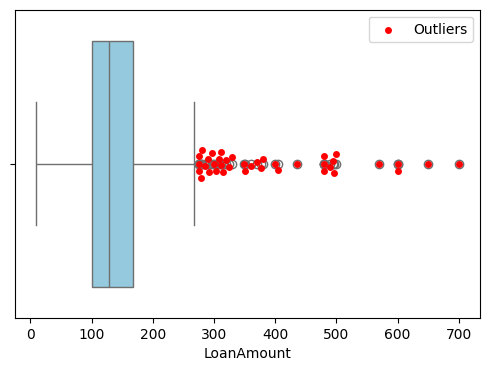

In [51]:
#Plot the box plot of the loanAmount column
plt.figure(figsize=(6,4))
sns.boxplot(x=raw_data_df['LoanAmount'], color='skyblue')
sns.swarmplot(x=Outliers_df, color='red', label='Outliers')
plt.show() 

#### Outliers are 6.68% of the data
- What these outliers mean for our data:<br><br>
  - All the outliers lie above the Boundry: Q3 + 1.5*inter_quartile_range
  - These are applicants seeking an exceptionally high loan.
  - These high loans may be considered a risk for the company.
  - And because they constitute to only 6.68% of the data they are not regular occurences.
  Thus keeping them might affect the model during training (this will be explored once the model is trained) and cause skewness of data. 
  - For now these outliers will be removed

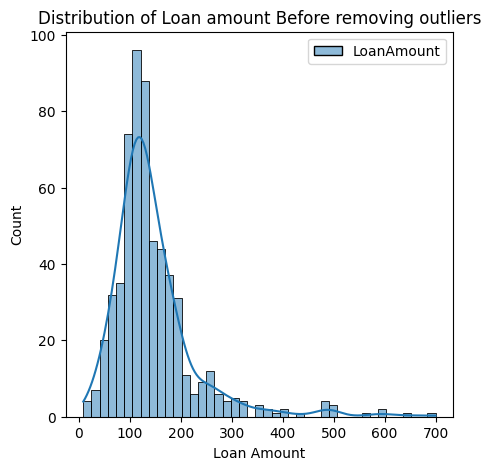

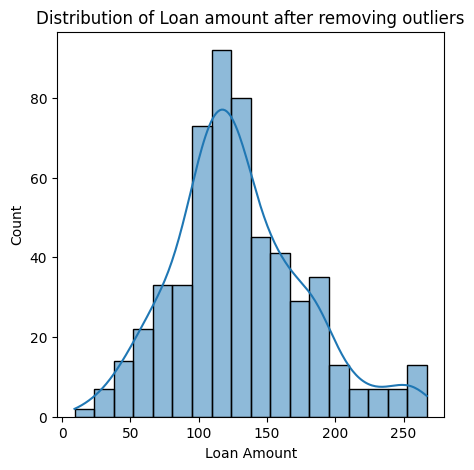

In [52]:
#removing Outliers
#Drop the whole rows with outliers was using inplace !(run once)
raw_data_df.drop(outliers_indexes, inplace=True)

#check the distribution of loan amount:
plt.figure(figsize=(5, 5))
sns.histplot(loanAmount_df, kde=True)
plt.title('Distribution of Loan amount Before removing outliers')
plt.xlabel('Loan Amount')

 
plt.figure(figsize=(5, 5))
sns.histplot(raw_data_df['LoanAmount'], kde=True)
plt.title('Distribution of Loan amount after removing outliers')
plt.xlabel('Loan Amount')
plt.show()

In [53]:
#Statistical measures

#Central Tendency
mean = raw_data_df['LoanAmount'].mean().__round__(2)
median = raw_data_df['LoanAmount'].median().__round__(2)

#Spread or Dispersion
std = raw_data_df['LoanAmount'].std().__round__(2)
min = raw_data_df['LoanAmount'].min().__round__(2)
max = raw_data_df['LoanAmount'].max().__round__(2)

#Skewness
skew_coef =raw_data_df['LoanAmount'].skew().__round__(2)
#K>0, heavier tails, K<0: lighter tails, k approx. 0: SIMILAR TAILS TO NORMAL
kurt_coeff = raw_data_df['LoanAmount'].kurt().__round__(2)
 
print(f"Central Tendency:\n mean: {mean}\t median: {median}\n")
print(f"Spread:\n Standard deviation: {std}\t min:{min}\tmax:{max}\n")
print(f"Skewness coefficient: {skew_coef}\tKurtosis coefficent: {kurt_coeff}")


Central Tendency:
 mean: 129.0	 median: 124.0

Spread:
 Standard deviation: 47.93	 min:9.0	max:267.0

Skewness coefficient: 0.5	Kurtosis coefficent: 0.34


### key take away:
- Majority of applicants apply for loan amount close to the average 129.19 (mean) as the median of 125 is not far from the mean.<br><br>
- The standard deviation of 46.5 indicates the loans applicants apply for, vary from the mean by approximately 46.5.<br><br>
- The maximum loan of 260 is alomst (mean + 3*std) away from the mean.<br><br>
- The minimum value of 9, is approximately (mean - 2.6*std) away from the mean, we expect it to be (mean - 3*std), this may show a slight skewness toward to higher loans amount. Applicants may be applying for higher loan amounts over lower ones.<br><br>
- Kurtosis coefficent of 0.37, suggests a similar distribution to the normal distribution.<br><br>   
- The skewness coefficent of 0.43, suggests that the data is slightly right-skewed, this could indicate there is still some larger loan amounts (outliers) skewing the data slightly to the right, but not heavily as the skewness values lies between [-0.5, 0.5]. Thus these large loan amounts wont cause much bias when training the model.

##### Bivariant analysis
Aim: Explore and understand the relationship between Loan amounts and Loan status. 

In [54]:
fig = px.box(data_frame=raw_data_df['LoanAmount'], x='LoanAmount', color=raw_data_df['Loan_Status'],
                 title=f'BoxPlot for Feature:LoanAmount against the Target: Loan_Status')
fig.update_layout(xaxis_title=f'Loan_Status Feature')
fig.show()

#### Observation
From the above plots, there is still a significant amount of outliers in both 'Yes' and 'No' plots. however, due to the removal of the outliers in the LoanAmount column previously, reomval of more outliers may compromise the size of the training and testing dataset. <br>
<br>
Hence, Log transformation will be used to reduce the impact of these outliers on the dataset. 

In [55]:
# Log transformation
raw_data_df['Log_LoanAmount'] = np.log(raw_data_df['LoanAmount']) #created a new column
#print(raw_data_df.columns)

# Plot the transformed data
fig = px.histogram(data_frame=raw_data_df, x='Log_LoanAmount', color='Loan_Status',
                   title='Histogram for Feature: LOG(LoanAmount) against the Target: Loan_Status',
                   facet_col='Loan_Status')
fig.update_layout(xaxis_title='Log(LoanAmount) Feature', showlegend=False)
fig.show()


Statistical analysis

In [56]:
#To avoid scaling back using exp() well work with LoanAmount over log_LoanAmount
#Seperate column between yes and no
yes_df = raw_data_df[raw_data_df['Loan_Status'] == 'Y'][['LoanAmount']]
no_df = raw_data_df[raw_data_df['Loan_Status'] == 'N'][['LoanAmount']]

#Stats

#mean
mean_yes = yes_df['LoanAmount'].mean().__round__(2)
mean_no = no_df['LoanAmount'].mean().__round__(2)

#standard deviation
std_yes = yes_df['LoanAmount'].std().__round__(2)
std_no = no_df['LoanAmount'].std().__round__(2)

#skewness
skew_yes = yes_df['LoanAmount'].skew().__round__(2)
skew_no = no_df['LoanAmount'].skew().__round__(2)

#min max
min_yes = yes_df['LoanAmount'].min().__round__(2)
max_yes =yes_df['LoanAmount'].max().__round__(2)
mode_yes =yes_df['LoanAmount'].mode().__round__(2)
min_no = no_df['LoanAmount'].min().__round__(2)
max_no =no_df['LoanAmount'].max().__round__(2)

#print(yes_df.columns)
print(f"Total number:\n Yes: {len(yes_df)}\tNo: {len(no_df)}\n")
print(f"Range of Values:")
print(f"\tYes\n \tmin: {min_yes}\t max: {max_yes}\t mode: {mode_yes}")
print(f"\tNo\n min: {min_no}\t max: {max_no}")
print(f"The mean (average):\nYes: {mean_yes}\tNo: {mean_no}\n")
print(f"The Standard deviation (spread):\nYes: {std_yes}\tNo: {std_no}\n")
print(f"The skewness coeffcient:\nYes: {skew_yes}\tNo: {skew_no}\n")


Total number:
 Yes: 398	No: 177

Range of Values:
	Yes
 	min: 17.0	 max: 267.0	 mode: 0    120.0
Name: LoanAmount, dtype: float64
	No
 min: 9.0	 max: 265.0
The mean (average):
Yes: 128.01	No: 131.31

The Standard deviation (spread):
Yes: 47.1	No: 49.88

The skewness coeffcient:
Yes: 0.48	No: 0.54



### Key Takeawyas:
- There is a total of 397 yes' and 176 no's for loan status for each group (69.28% of the data has a 'Yes' qualifying loan status). 
-From the histograms, most loanAmounts under the class Yes lie betweeen 120 and 181.27. 
- Although the LoanAmounts in this range, under 'No', amount to the highest count for this class, there is a significantly higher number of loanAmounts in class 'Yes' in this range than there are in class 'No'.
- The mean and the standard deviation values do not differ by much, but the significant difference in the number of loanAmount in class 'Yes' and in class 'No' suggests that loan amounts do affect the loan status to some degree.
- lastly, it can be drawn that loan amounts between 0 and 16 will fall under class 'No'.   


#### Self Employed

In [57]:
Self_Employed_df = raw_data_df[["Self_Employed"]] #used as copy for plotting if required
print(f"Number of missing values in Self_Employed: {Self_Employed_df['Self_Employed'].isnull().sum()}")

Number of missing values in Self_Employed: 29


Self Employed:
- Can take on 2 values (No/Yes).
  - No: Employed applicants
  - Yes: Self-Employed applicanrs
- Has 29 missing values
Missing Values:
the missing values in the categorical column 'Self_Employed', will be filled using the mode of this column.


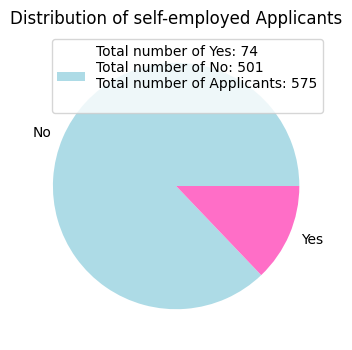

In [58]:
#fill missing values using mode of self employed
raw_data_df['Self_Employed'] = raw_data_df['Self_Employed'].fillna(raw_data_df['Self_Employed'].mode()[0])
Self_Employed_df = raw_data_df[['Self_Employed']]

#Pie chart for univariant analysis
self_employed_totals = raw_data_df['Self_Employed'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(self_employed_totals,labels = self_employed_totals.index, colors=['#ADDBE6', '#FF6EC7']) 
plt.title('Distribution of self-employed Applicants')
plt.legend(labels=[f"Total number of Yes: {self_employed_totals['Yes']}\n"
                   f"Total number of No: {self_employed_totals['No']}\n"
                   f"Total number of Applicants: {len(raw_data_df)}\n"],
                    loc='upper right')
plt.show()

It is expected that majority of loan applicants will be employed.

##### Bivariant Analysis

In [59]:
#Group the self employed feature based on the loan status

selfEmp_loan_df = pd.DataFrame(
    raw_data_df[['Self_Employed','Loan_Status']].groupby(['Loan_Status'])
    .value_counts().reset_index()
).rename(columns={0:'count'})

In [60]:
fig = px.bar(
    data_frame=selfEmp_loan_df, 
    x='Self_Employed', 
    y='count', 
    facet_col='Loan_Status', 
    color=selfEmp_loan_df['Loan_Status']#.astype(str) 
)

fig.update_layout(xaxis_title='Self Employed', yaxis_title='Count')
fig.show()

In [61]:
emp_yes = selfEmp_loan_df.loc[(selfEmp_loan_df['Loan_Status'] == 'Y')
                             & (selfEmp_loan_df['Self_Employed'] == 'No'), 'count'].values[0]
self_emp_yes = selfEmp_loan_df.loc[(selfEmp_loan_df['Loan_Status'] == 'Y')
                             & (selfEmp_loan_df['Self_Employed'] == 'Yes'), 'count'].values[0]

emp_no = selfEmp_loan_df.loc[(selfEmp_loan_df['Loan_Status'] == 'N')
                             & (selfEmp_loan_df['Self_Employed'] == 'No'), 'count'].values[0]
self_emp_no = selfEmp_loan_df.loc[(selfEmp_loan_df['Loan_Status'] == 'N')
                             & (selfEmp_loan_df['Self_Employed'] == 'Yes'), 'count'].values[0]
print('Successful Loan Application status:')
print(f"\t Employed Applicants: {emp_yes}")
print(f"\t self-employed Applicants: {self_emp_yes}\n")

print('Unsuccessful Loan Application status:')
print(f"\t Employed Applicants: {emp_no}")
print(f"\t self-employed Applicants: {self_emp_no}")

Successful Loan Application status:
	 Employed Applicants: 348
	 self-employed Applicants: 50

Unsuccessful Loan Application status:
	 Employed Applicants: 153
	 self-employed Applicants: 24


key Takeaways:
- Employed applicants are more likely to qualify to apply for a loan than self-employed applicants.
- only 12.56% of self-employed applicants qualify to apply for a loan.
- There are more employed applicants seeking a loan than self-employed applicants.

### Inside pre_proccessing.py
Pre_proccessing functions to clean, handlie missing values, outlers and preproccess the validation.csv data.

In [62]:
def load_data():
    #load the data just move 1 folders out of current dir
    raw_data_df = pd.read_csv("../data/raw_data.csv")
   
    return raw_data_df

def load_data_for_validation():
    #load the data just move 1 folders out of current dir
    raw_data_df = pd.read_csv("../data/validation.csv")
   
    return raw_data_df

#load_data()
#load_data_for_validation()

In [63]:

def loanAmount(raw_data_df):
    
    #fill missing values with mean
    raw_data_df['LoanAmount'].fillna(
        raw_data_df['LoanAmount'].mean(), inplace=True
    )

    #find the quartile ranges to identify outliers
    Q1= raw_data_df['LoanAmount'].quantile(0.25) 
    Q3= raw_data_df['LoanAmount'].quantile(0.75)

    inter_quartile_range = Q3-Q1

    #find the inter quartile ranges
    lower_bound = Q1 - (1.5*inter_quartile_range)
    upper_bound = Q3 + (1.5*inter_quartile_range)

    #isolate outliers
    outliers_indexes = []

    for index, row in enumerate(raw_data_df['LoanAmount']):
        if row < lower_bound:
            outliers_indexes.append(index)
        else:
            if row > upper_bound:
                outliers_indexes.append(index)  

    #removing Outliers
    #Drop the whole rows with outliers 
    raw_data_df.drop(outliers_indexes, inplace=True)
    return raw_data_df

#preproccess Self_Employed
def self_Employed(data_df):
    #fill missing values using mode of self employed
    data_df['Self_Employed'] = data_df['Self_Employed'].fillna(data_df['Self_Employed'].mode()[0])
    return data_df

#preproccess Loan Amount term
def loan_amount_term(data):
    # Replace the missing the data with the most frequent data in months
    frequentVal = data['Loan_Amount_Term'].mode().values[0]

    # Replace the NaN values with the frequent val:
    data['Loan_Amount_Term'].fillna(frequentVal, inplace=True)
    return data

# Applicant Income
def applicant_income(data):
    
    #Outliers handling
    # Remove outliers of ApplicantIncome
    Q1 = data['ApplicantIncome'].quantile(0.25)
    Q3 = data['ApplicantIncome'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outlier_mask = (data['ApplicantIncome'] > lower_bound) & (data['ApplicantIncome'] < upper_bound)

    data = data[outlier_mask]
    return data

#Credit History
def Credit_History(raw_data_df):
    # replace empty rows with the mode of the column
    raw_data_df["Credit_History"]= raw_data_df["Credit_History"].fillna(raw_data_df["Credit_History"].mode()[0])
    
    #replace credit/noncredit values with 0/1
    has_credit = 0
    no_credit = 0

    for row in raw_data_df["Credit_History"]:
        if row == 1:
            has_credit += 1
        else:
            no_credit += 1        
    return raw_data_df

#Gender
def gender(data):
    # Find the mode of the gender data
    data['Gender'] = (data['Gender']
    .fillna(data['Gender'].mode()[0])
    )
    return data

#Married
def married(data):
    #missing values with mode
    data['Married'] = (data['Married']
    .fillna(data['Married'].mode()[0])
    )
    return data

#Education
def education(data):
    #missing values with mode
    data['Education'] = (data['Education']
    .fillna(data['Education'].mode()[0])
    )
    return data
#CoApplicant
def coapplicantIncome(data):
    #fill missing values with mean
    data['CoapplicantIncome'].fillna(
        data['CoapplicantIncome'].mean(), inplace=True
    )
    
    #Outliers
    Q1= data['CoapplicantIncome'].quantile(0.25) 
    Q3= data['CoapplicantIncome'].quantile(0.75)

    inter_quartile_range = Q3-Q1

    #find the inter quartile ranges
    lower_bound = Q1 - (1.5*inter_quartile_range)
    upper_bound = Q3 + (1.5*inter_quartile_range)
    #isolate outliers
    outliers_indexes = []
    for index, row in enumerate(data['CoapplicantIncome']):
        if row < lower_bound:
            outliers_indexes.append(index)
        else:
            if row > upper_bound:
                outliers_indexes.append(index)  
        # Reset index of the DataFrame
    data.reset_index(drop=True, inplace=True)
    #removing Outliers
    data.drop(outliers_indexes, inplace=True)
    
    return data

#Property Area
def property_area(data):
    #missing values with mode
    data['Property_Area'] = (data['Property_Area']
    .fillna(data['Property_Area'].mode()[0])
    )
    return data

#dependents
def dependants(data):
    data['Dependents'] = (data['Dependents']
    .fillna(data['Dependents'].mode()[0])
    )
    #print(data['Dependents'].unique())
    return data

#finally drop the first column for Applicant loan identification
def drop_id(data):
    data.drop('Loan_ID', axis = 1, inplace = True)
    return data

Pipeline the above functions to stream line pre_proccessing steps.

In [64]:
#call this function when we start preproccessing
def preproccessing():
    return (load_data()
            .pipe(loanAmount)
            .pipe(self_Employed)
            .pipe(loan_amount_term)
            .pipe(applicant_income)
            .pipe(Credit_History)
            .pipe(gender).pipe(married)
            .pipe(coapplicantIncome)
            .pipe(education)
            .pipe(dependants)
            .pipe(drop_id)
    )
    
#call this function to preproccess validation.csv data 
def preproccessing_for_validation():
    return (load_data_for_validation()
            .pipe(loanAmount)
            .pipe(self_Employed)
            .pipe(loan_amount_term)
            .pipe(applicant_income)
            .pipe(Credit_History)
            .pipe(gender).pipe(married)
            .pipe(coapplicantIncome)
            .pipe(education)
            .pipe(dependants)
            .pipe(drop_id)
    )
data = preproccessing_for_validation()
#print(data.isnull().sum())

### Inside data_transformation.py
what was done:
- One-hot-Encoding of the following columns:
  - Gender
  - Married
  - Education
  - Self employed

- Label Encoding of the following columns:
  - Property area
  - dependents
  - credit history
  - loan status

One-hot encoding using category_encoders

In [65]:
def ohe_columns(data):
    columns_to_ohe = ['Gender', 'Married','Education','Self_Employed']
    ohe = OneHotEncoder(
       use_cat_names = True,
       cols = columns_to_ohe 
    )
    ohe_df = ohe.fit_transform(data)
    return ohe_df

label encoding using sklearn

In [66]:
def label_encoding(data):
    #Label:
    #Property_Area
    #Dependents
    #Credit_History
    #Loan_Status
    label_encoding = LabelEncoder()
    columns_to_LE = ['Property_Area', 'Dependents',
                     'Credit_History', 'Loan_Status']
    
    for col in columns_to_LE:
        data[col] = label_encoding.fit_transform(data[col]).astype(int)
    return data


The transformation of the validation.csv data before predictions are made on it, includes new additional columns that arose during feature engineering. These new columns will be discussed under feature engneering. However, before predictions can be made, the data must also be transformed under this file.

In [67]:
def ohe_columns_validation(data):
    columns_to_ohe = ['Gender', 'Married','Education','Self_Employed']
    ohe = OneHotEncoder(
       use_cat_names = True,
       cols = columns_to_ohe 
    )
    ohe_df = ohe.fit_transform(data)
    return ohe_df

def label_encoding_validation(data):
    #Label:
    #Property_Area
    #Dependents
    #Credit_History
    #Loan_Status
    label_encoding = LabelEncoder()
    columns_to_LE = ['Property_Area', 'Dependents',
                     'Credit_History']
    
    for col in columns_to_LE:
        data[col] = label_encoding.fit_transform(data[col]).astype(int)
    return data

Pipeline similar to the previous to streamline the transformation proccess.

In [68]:
def transformation():
    return (preproccessing().pipe(ohe_columns).pipe(label_encoding))

#pipeline for transformation of validation.csv data
def transformation_for_validation():
    data_df = preproccessing_for_validation()
    data_df['TotalIncome'] =  data_df['ApplicantIncome'] + data_df['CoapplicantIncome']
    data_df['LoanAmountRatio'] =  data_df['LoanAmount']/data_df['TotalIncome']
    data_df['LoanRepaymentCap'] =  data_df['ApplicantIncome']/data_df['LoanAmount']
    data_df['Loan_Amount_Term'] = np.log(data_df["Loan_Amount_Term"])
    
    return (data_df.pipe(ohe_columns_validation).pipe(label_encoding_validation))


In [69]:
#print(preproccessing().isnull().sum())
#print(transformation_for_validation().isnull().sum())

### Decision tree
Due to the categorical nature of the target data, the decision tree model was the first chosen model to train and test the raw data. It provided a clear interpretability of the importance of the features at hand. 

### Inside decision_tree.py


In [70]:
#function to split the data and calculate the baseline 
#accuracy score
def split_data(data_df):
    X = data_df.drop(columns=['Loan_Status'], inplace = False)
    Y = data_df['Loan_Status']

    #split data into training and testing 80/20
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


    # Base line model accuracy score
    acc_baseline = y_train.value_counts(normalize=True).max()
    print(f"Baseline Accuracy: {round(acc_baseline*100,2)}")
    return X_train, X_test, y_train, y_test

#Base-Line accuracy = 69.88


fitting and training the model

In [71]:
def dec_Tree(X_train, X_test, y_train, y_test):
    depth_hyperparams = range(1,20)
    #hyperparameter tuning
    training_acc = [] #accuracy score during training of model
    validation_acc = [] #accuracy during testing of model
    
    #create a for loop to hold the scores 
    for depth in depth_hyperparams:
        
        model = make_pipeline(
            DecisionTreeClassifier(max_depth=depth, random_state=42)
        )
        
        #fit model
        model.fit(X_train, y_train)
        
        #calculate the accuracy scores and append
        training_acc.append(model.score(X_train, y_train))
        validation_acc.append(model.score(X_test, y_test))
    return depth_hyperparams, training_acc, validation_acc


displaying the accuracy scores

In [72]:
def display_acc_scores(depth, train_acc, val_acc):
    #create a df to store these scores
    df = pd.DataFrame(
        data = {'Training': train_acc, 'Validation': val_acc},
        index=depth
    )
    #print(df)
    
    #graph plot
    fig = px.line(data_frame=df, x = depth, y = ['Training', 'Validation'],
                  title= 'Training and Validation (Testing) accuracy scores',
                  labels={'value': 'Accuracy', 'Depth': 'Tree Depth', 'variable': 'Dataset'})
    fig.show()
    return

In [73]:
#plot the tree
def dt_plt(final_model):
    ft_names = final_model.named_steps.decisiontreeclassifier.feature_names_in_
    plt.figure(figsize=(18,12))
    plot_tree(
        decision_tree=final_model.named_steps['decisiontreeclassifier'], 
        filled=True, 
        max_depth=4, 
        feature_names=ft_names, 
        class_names=True
    )
    plt.axis('off')
    plt.show()
    return

In [74]:
data_df = transformation()
data_df['TotalIncome'] =  data_df['ApplicantIncome'] + data_df['CoapplicantIncome']
   
X_train, X_test, y_train, y_test = split_data(data_df)
depth, train_acc, val_acc = dec_Tree(X_train, X_test, y_train, y_test)
display_acc_scores(depth, train_acc, val_acc)

Baseline Accuracy: 69.88


from the above plot, a depth value of 3 will yeild the hiighest accuracy score of 85.57%. 

Functions to call once the accuracy scores have been plotted to train on the optimal depth value that will yeild the best accuracy score. The save_model function will save the model as a .pk1 file.

In [75]:
def final_model(model_nr,depth, X_train, X_test, y_train, y_test):
    model_dt = make_pipeline(
        DecisionTreeClassifier(max_depth=depth, random_state=42)
    )
    
    model_dt.fit(X_train, y_train)
    y_pred_scores = model_dt.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_scores)
    print(f"The accuracy score is: {round(accuracy*100,2)}% before feature engineering using decision tree")
    save_model(model_nr, model_dt)
    
    #print decision tree to show ft importance
    dt_plt(model_dt)
    return  model_dt

def save_model(which_model, model_dt):
    if which_model == 0:
        joblib.dump(model_dt, '../artifacts/model_b4_ft_eng.pk1') 
        #print("Done saving model before ft engineering.")
    else:
        joblib.dump(model_dt, '../artifacts/model_after_ft.pk22')
           
    return

The accuracy score is: 85.58% before feature engineering using decision tree


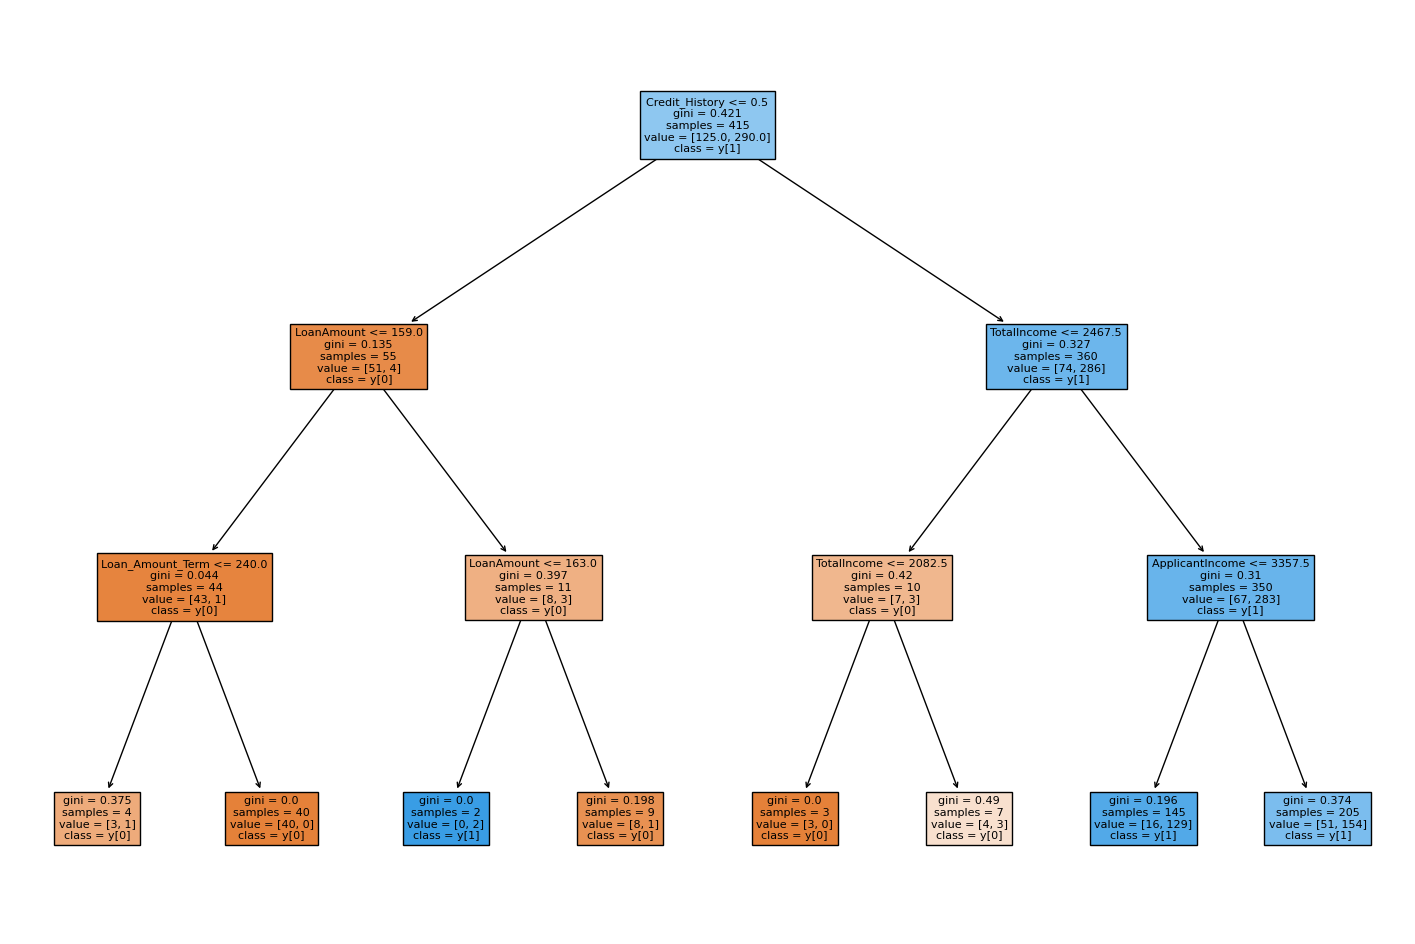

In [76]:
#Evalueate the final model before ft. eng 
final_depth = 3
model_dt = final_model(0,final_depth, X_train, X_test, y_train, y_test)

Extracting feature importance

In [77]:
#Extract and view important features
def ft_importance(model_dt):
    # Extract features and their coefficients
    coef = model_dt.named_steps["decisiontreeclassifier"].feature_importances_
    ft = model_dt.named_steps['decisiontreeclassifier'].feature_names_in_

    # Convert to Pandas Series
    ft_importance = pd.Series(
        np.exp(coef), index=ft
        ).sort_values(ascending=True)
    
    #Plot ft importance
    # Create horizontal bar chart of feature importances
    fig = px.bar(
        data_frame=ft_importance, 
        x=ft_importance[:16].values, 
        y=ft_importance[:16].index, 
        title="Feature Importance"
    )

    fig.update_layout(xaxis_title='Gini Importance', yaxis_title='')
    fig.show()
    return

In [78]:
ft_importance(model_dt)

the Gini scale above tells us how important a feature is for making predictions. From the above a credit history is far more important than the total income of an applicant. Which logically makes sense, because an applicant with a good credit history is  as an asset to a bank over someone with a high income amount. This ensures credibilty of the applicant and their likelyhood to pay back a loan. 

function to start the whole proccess

In [79]:
def start_training():
    data_df = transformation()
    data_df['TotalIncome'] =  data_df['ApplicantIncome'] + data_df['CoapplicantIncome']
   
    X_train, X_test, y_train, y_test = split_data(data_df)
    depth, train_acc, val_acc = dec_Tree(X_train, X_test, y_train, y_test)
    display_acc_scores(depth, train_acc, val_acc)
    
    #Evalueate the final model before ft. eng 
    final_depth = 3
    model_dt = final_model(0,final_depth, X_train, X_test, y_train, y_test)
    ft_importance(model_dt)
    return

#start_training()

### Random Forest model

Random forest tree builds on the previos decision tree model. It is an ensamble learning technique that consists of multiple decision trees. It requires a n_esimator parameter that specifies the number of trees in the model. To make its prediction it averages the output of all these trees.

### inside the randomForest.py

split data

In [80]:
def split_data(data_df):
    X = data_df.drop(columns=['Loan_Status'], inplace = False)
    Y = data_df['Loan_Status']

    #split data into training and testing 80/20
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


    # Base line model accuracy score
    acc_baseline = y_train.value_counts(normalize=True).max()
    print(f"Baseline Accuracy: {round(acc_baseline*100,2)}")
    return X_train, X_test, y_train, y_test

#### Hyperparameter tuning:

tuning of n_estimator and the depth value

In [81]:
#RF hyper parameter tuning
def rf_hyperparam(X_train, X_test, y_train, y_test):
    n_estimators_range = [50,100,150,200]
    max_depths_range = range(1,16)
    
    training_acc = []
    validation_acc = []
    
    for n_estimators in n_estimators_range:
        for max_depth in max_depths_range:
            # Initialize Random Forest model with current hyperparameters
            rf_model = RandomForestClassifier(
                n_estimators=n_estimators, 
                max_depth=max_depth, random_state=42)
            
            rf_model.fit(X_train, y_train)
            
            training_acc.append(rf_model.score(X_train,y_train))
            validation_acc.append(rf_model.score(X_test,y_test))

    return n_estimators_range, max_depths_range, training_acc, validation_acc


#### Feature engineering
with the aim of imporiving the accuracy score from the last model the following features were engineered.
- TotalIncome: This represent the total income of the applicant and it is the sum of the applicant and co-applicant income.
-  LoanAmountRatio: this is the ratio of the loan to the applicant's income
- LoanRepaymentCap: This is the ratio of the applicant's income to the loan amount they are applying for. This value will indicate the applicant's capacity to repay the loan.
- Loan_Amount_Term: the loan term was replaced with it's scaled down version to reduce the impact of the outliers on the model training.


In [82]:
data_df = transformation()
data_df['TotalIncome'] =  data_df['ApplicantIncome'] + data_df['CoapplicantIncome']
    
    
#Replace loan amount with loan ratio
data_df['LoanAmountRatio'] =  data_df['LoanAmount']/data_df['TotalIncome'] 
#Loan Repayment capacity
data_df['LoanRepaymentCap'] =  data_df['ApplicantIncome']/data_df['LoanAmount']
#scale loan term period
data_df['Loan_Amount_Term'] = np.log(data_df["Loan_Amount_Term"])
 

accuracy scores

In [83]:
#ploting accuracy scores
def plot_acc_score(n_estimators_range, max_depth_range, train_acc, val_acc):
    # Create a DataFrame to store these scores
    acc_data_df = pd.DataFrame({
        'n_estimators': np.repeat(n_estimators_range, len(max_depth_range)),
        'max_depth': list(max_depth_range) * len(n_estimators_range),
        'Training': train_acc,
        'Validation': val_acc
    })

    for n_estimator in n_estimators_range:
        df = acc_data_df[acc_data_df['n_estimators'] == n_estimator]
        
        fig = px.line(data_frame=df,
                      x='max_depth',
                      y=['Training', 'Validation'],
                      title=f'Training and Validation (Testing) accuracy scores for Random Forest (n_estimators={n_estimator})',
                      labels={'value': 'Accuracy', 'max_depth': 'Max Depth', 'variable': 'Dataset'},
                      color_discrete_sequence=['blue', 'red']
                      )
        fig.show()

In [84]:
X_train, X_test, y_train, y_test = split_data(data_df)
(n_estimators_range, max_depths_range, 
    training_acc, validation_acc) = rf_hyperparam(X_train, X_test, y_train, y_test)
    
plot_acc_score(n_estimators_range, max_depths_range, 
    training_acc, validation_acc)

Baseline Accuracy: 69.88


A depth of 8 and a number estmator of 50 yeilds the highest accuracy score of 88.46% according to the plot.

final model: (stored as .pk2 file)

In [85]:
#train final model
def train_final_rf_model(X_train, X_test, y_train, y_test, n, depth):
    # Initialize Random Forest model with optimal hyperparameters
    rf_model = RandomForestClassifier(n_estimators=n, max_depth=depth, random_state=42)
    
    # Train the model
    rf_model.fit(X_train, y_train)
    
    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"The accuracy score is: {round(accuracy*100, 2)}% after feature training using the final Random Forest model.")
    
    # Save the model
    joblib.dump(rf_model, '../artifacts/rf_model_ft_eng.pk2')
    
    return rf_model

In [86]:
#n = 50 depth = 8 optimal from plots
train_final_rf_model(X_train, X_test, y_train, y_test, 100, 8)

The accuracy score is: 88.46% after feature training using the final Random Forest model.


RandomForestClassifier(max_depth=8, random_state=42)

function to run to start the whole proccess

In [87]:
def start_training():
    data_df = transformation()
    data_df['TotalIncome'] =  data_df['ApplicantIncome'] + data_df['CoapplicantIncome']
    
    
    #Replace loan amount with loan ratio
    data_df['LoanAmountRatio'] =  data_df['LoanAmount']/data_df['TotalIncome']
    
    
    #Loan Repayment capacity
    data_df['LoanRepaymentCap'] =  data_df['ApplicantIncome']/data_df['LoanAmount']
    
    #scale loan term period
    data_df['Loan_Amount_Term'] = np.log(data_df["Loan_Amount_Term"])
    
    #Drop to reduce redundancy: reduced accuracy score by 2%
    #data_df.drop(['ApplicantIncome', 'CoapplicantIncome'], axis=1, inplace=True)
    #data_df.drop(['LoanAmount'], axis=1, inplace=True)
    #data_df.drop(['Education_Graduate', 'Education_Not Graduate'], axis=1, inplace=True)
    
    X_train, X_test, y_train, y_test = split_data(data_df)
    (n_estimators_range, max_depths_range, 
    training_acc, validation_acc) = rf_hyperparam(X_train, X_test, y_train, y_test)
    
    plot_acc_score(n_estimators_range, max_depths_range, 
    training_acc, validation_acc)
    
    #n = 100 depth = 8 optimal from plots
    train_final_rf_model(X_train, X_test, y_train, y_test, 100, 8)
    
    return
#start_training()

### Inside make_predictions.py

Objective:
- load the stored random forest model (.pk2)
- Extract the required feature names from the model
- Proccess and transform the validation.csv data so it fits the required structure of the model for predictions.
- make predictions

In [88]:
#load the model
# Load the model
model = joblib.load('../artifacts/rf_model_ft_eng.pk2')

# Extract features to ensure order
ft_names = model.feature_names_in_
val_data = transformation_for_validation()
val_data = val_data[ft_names]

predictions = model.predict(val_data)
print(predictions)

[1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0
 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0
 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0
 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1]


### Key takeaways
- Scaling down logarithmically the term feature improved the accuracy score without compromising the size of the data.
- The final random forest model improved the accuracy score from:
    - Baseline: 69.88%, 
    - Decision tree: 85.58%, to 
    - Random forest: 88.46% 
    however this 2.58% improvement in accuracy score came at a cost of a higher resource requirement for proccessing, due to the mutiple tree nature of the rf model. Thus, for this project the decision tree was sufficient.  